In [2]:
#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics
import wordcloud #Makes word clouds

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import nltk #the Natural Language Toolkit
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline


#For ML
import sklearn
import sklearn.feature_extraction.text
import sklearn.decomposition
from sklearn import preprocessing, linear_model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.datasets import fetch_20newsgroups, make_blobs
from sklearn.feature_extraction.text import TfidfVectorizer  #Feature extraction
from sklearn.naive_bayes import MultinomialNB #Our learner.
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn import neighbors
import pandas as pd

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
from matplotlib.colors import ListedColormap
import seaborn #Makes plots look nice, also heatmaps
import scipy as sp #for interp

%matplotlib inline

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas
import requests
import json
import math

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
stop_words_nltk = nltk.corpus.stopwords.words('english')
snowball = nltk.stem.snowball.SnowballStemmer('english')

def normlizeTokens(tokenLst, stopwordLst = None, stemmer = None, lemmer = None, vocab = None):
    #We can use a generator here as we just need to iterate over it

    #Lowering the case and removing non-words
    workingIter = (w.lower() for w in tokenLst if w.isalpha())

    #Now we can use the semmer, if provided
    if stemmer is not None:
        workingIter = (stemmer.stem(w) for w in workingIter)

    #And the lemmer
    if lemmer is not None:
        workingIter = (lemmer.lemmatize(w) for w in workingIter)

    #And remove the stopwords
    if stopwordLst is not None:
        workingIter = (w for w in workingIter if w not in stopwordLst)
        
    #We will return a list with the stopwords removed
    if vocab is not None:
        vocab_str = '|'.join(vocab)
        workingIter = (w for w in workingIter if re.match(vocab_str, w))
    
    return list(workingIter)

In [4]:
try:
    df = pandas.read_pickle('data/cmv_data.pkl')
    #edf = pandas.read_pickle('data/extrap.pkl')
except:
    df = pandas.read_pickle('cmv_data.pkl')
    #edf = pandas.read_pickle('extrap.pkl')

#df = df.sample(frac = .1)

# cols = np.intersect1d(df.columns, edf.columns)
# edf = edf[cols]
# df.append(edf)
# df['exp'] = False
# edf['exp'] = True
# df = pd.concat([df, edf], axis=0)

#take out rows where comment is '[removed]' or '[deleted]'
df = df[(df['com_text']!='[deleted]')&(df['com_text']!='[removed]')]

# df['tokenized_com'] = df['com_text'].apply(lambda x: nltk.word_tokenize(x))
# df['normalized_com'] = df['tokenized_com'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))

#splitting data
# data_train, data_test = train_test_split(df, test_size=0.3, random_state=123)
# data_train['is_train'] = True
# data_test['is_train'] = False
# edf = df[df['exp']==True]



To get an idea of topic distribution of 1000 posts that we've collected, we will perform clustering and topic modeling on these posts.

In [5]:
#df['sub_text'].shape #2878
sub = df['sub_text'].unique()
#sub.shape #758

d = {'sub_text': sub}
subDF = pd.DataFrame(data = d)
subDF['tokenized_sub'] = subDF['sub_text'].apply(lambda x: nltk.word_tokenize(x))
subDF['normalized_sub'] = subDF['tokenized_sub'].apply(lambda x: normlizeTokens(x, stopwordLst = stop_words_nltk, stemmer = snowball))
subDF[:10]

,sub_text,tokenized_sub,normalized_sub
0,I voted remain. I have just woken up to the Le...,"[I, voted, remain, ., I, have, just, woken, up...","[vote, remain, woken, leav, victori, concern, ..."
1,Libraries provide communities many benefits ou...,"[Libraries, provide, communities, many, benefi...","[librari, provid, communiti, mani, benefit, ou..."
2,Shameless Plug: [CMV post - State lotteries ar...,"[Shameless, Plug, :, [, CMV, post, -, State, l...","[shameless, plug, cmv, post, state, lotteri, r..."
3,Hello CMV!\n\nFirst of all regarding my own id...,"[Hello, CMV, !, First, of, all, regarding, my,...","[hello, cmv, first, regard, idea, polit, would..."
4,I feel like there's no reason to vote in the p...,"[I, feel, like, there, 's, no, reason, to, vot...","[feel, like, reason, vote, primari, presidenti..."
5,**TL;DR: In order for the American people to h...,"[**TL, ;, DR, :, In, order, for, the, American...","[dr, order, american, peopl, signific, role, c..."
6,I could not feel more strongly about this. It ...,"[I, could, not, feel, more, strongly, about, t...","[could, feel, strong, absolut, ridicul, person..."
7,"I'm Dutch, and here you can drink alcohol when...","[I, 'm, Dutch, ,, and, here, you, can, drink, ...","[dutch, drink, alcohol, sixteen, next, age, ra..."
8,I believe that all countries should open their...,"[I, believe, that, all, countries, should, ope...","[believ, countri, open, border, fashion, membe..."
9,"The fact is that the vast majority of males, e...","[The, fact, is, that, the, vast, majority, of,...","[fact, vast, major, male, especi, circumcis, h..."


In [6]:
#initialize tf-idf feature matrix
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
subTFVects = TFVectorizer.fit_transform(sub)
subTFVects.shape

(831, 1000)

# Flat clustering with k-means

(831,)
(831,)


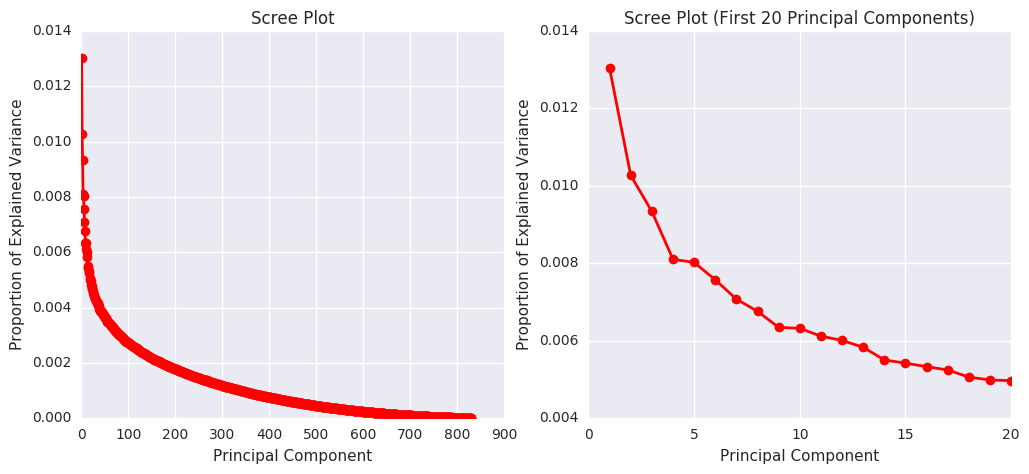

In [11]:
#First, use PCA to reduce the feature matrix
PCA = sklearn.decomposition.PCA
pca = PCA().fit(subTFVects.toarray())
reduced_data = pca.transform(subTFVects.toarray())

#use scree plot to determine the number of dimensions
n = subTFVects.shape[0]
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
eigen_vals = np.arange(n) + 1

#print(pca.explained_variance_ratio_)
print (eigen_vals.shape)
print(pca.explained_variance_ratio_.shape)

ax1.plot(eigen_vals, pca.explained_variance_ratio_, 'ro-', linewidth=2)
ax1.set_title('Scree Plot')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Proportion of Explained Variance')

ax2 = fig.add_subplot(122)
eigen_vals = np.arange(20) + 1
ax2.plot(eigen_vals, pca.explained_variance_ratio_[:20], 'ro-', linewidth=2)
ax2.set_title('Scree Plot (First 20 Principal Components)')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Proportion of Explained Variance')
plt.show()

In [9]:
print (eigen_vals.shape)
print(pca.explained_variance_ratio_.shape)

(20,)
(831,)


Looking at the scree plot, it seems reasonable to use top 15 components.

For n_clusters = 10 The average silhouette_score is : 0.163740891167


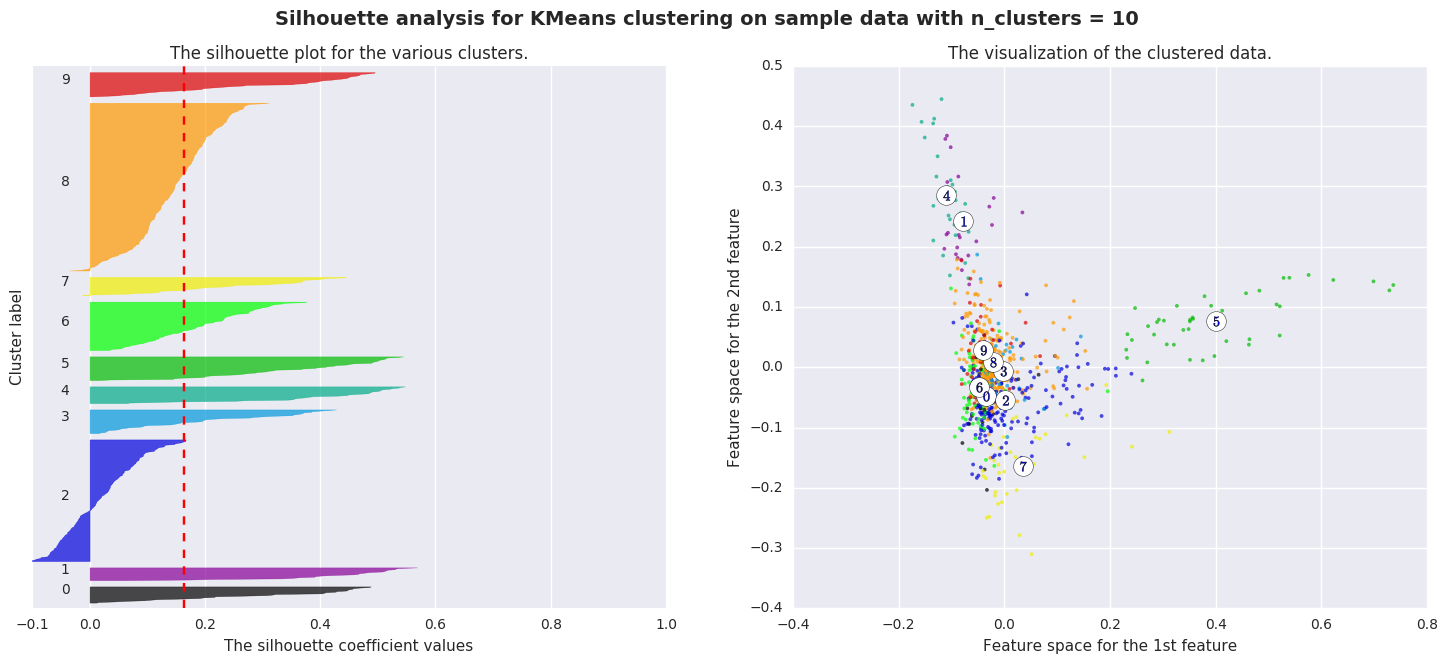

For n_clusters = 15 The average silhouette_score is : 0.16886837936


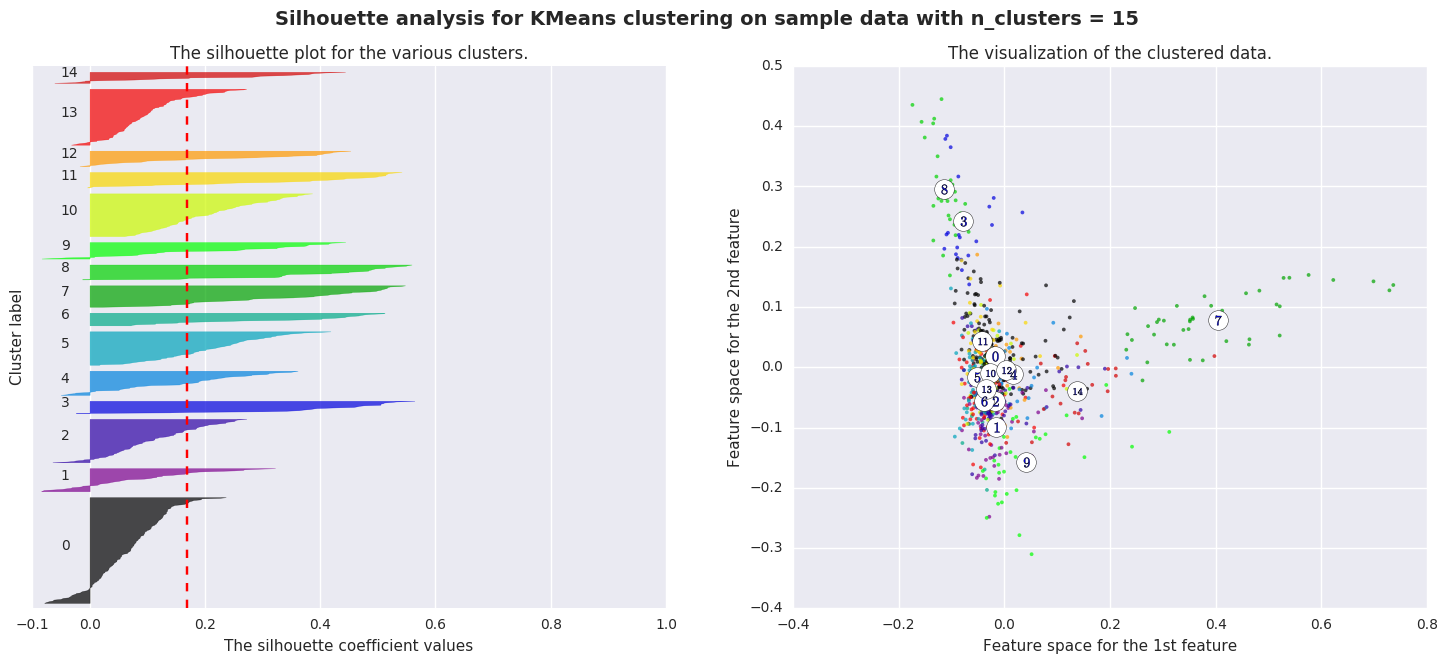

For n_clusters = 16 The average silhouette_score is : 0.172121644316


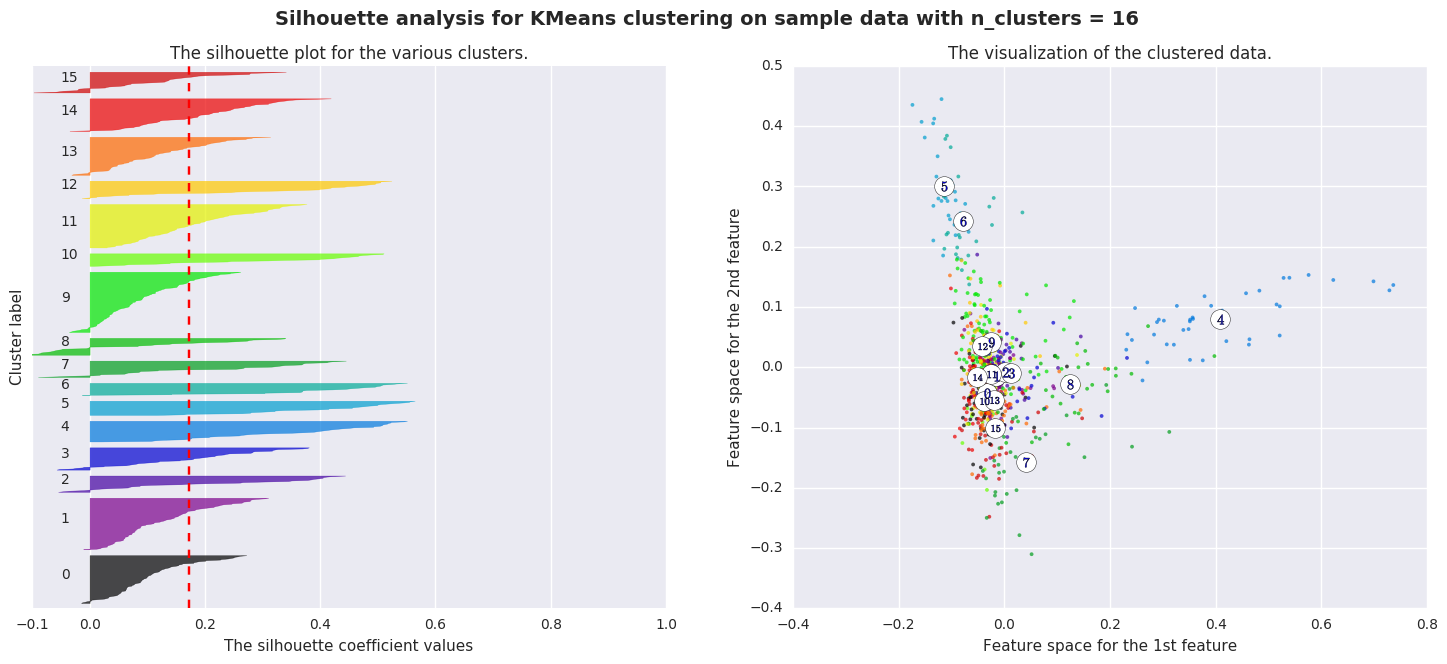

For n_clusters = 17 The average silhouette_score is : 0.16630836453


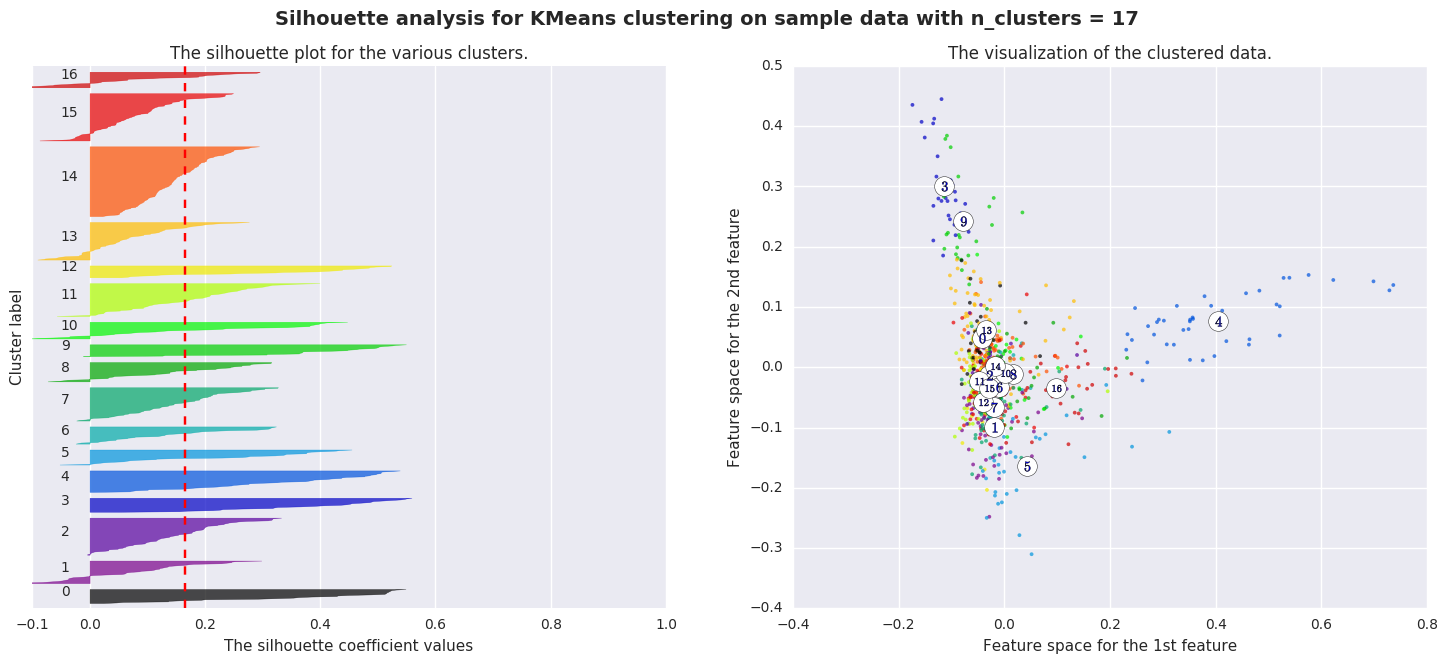

For n_clusters = 18 The average silhouette_score is : 0.165793456099


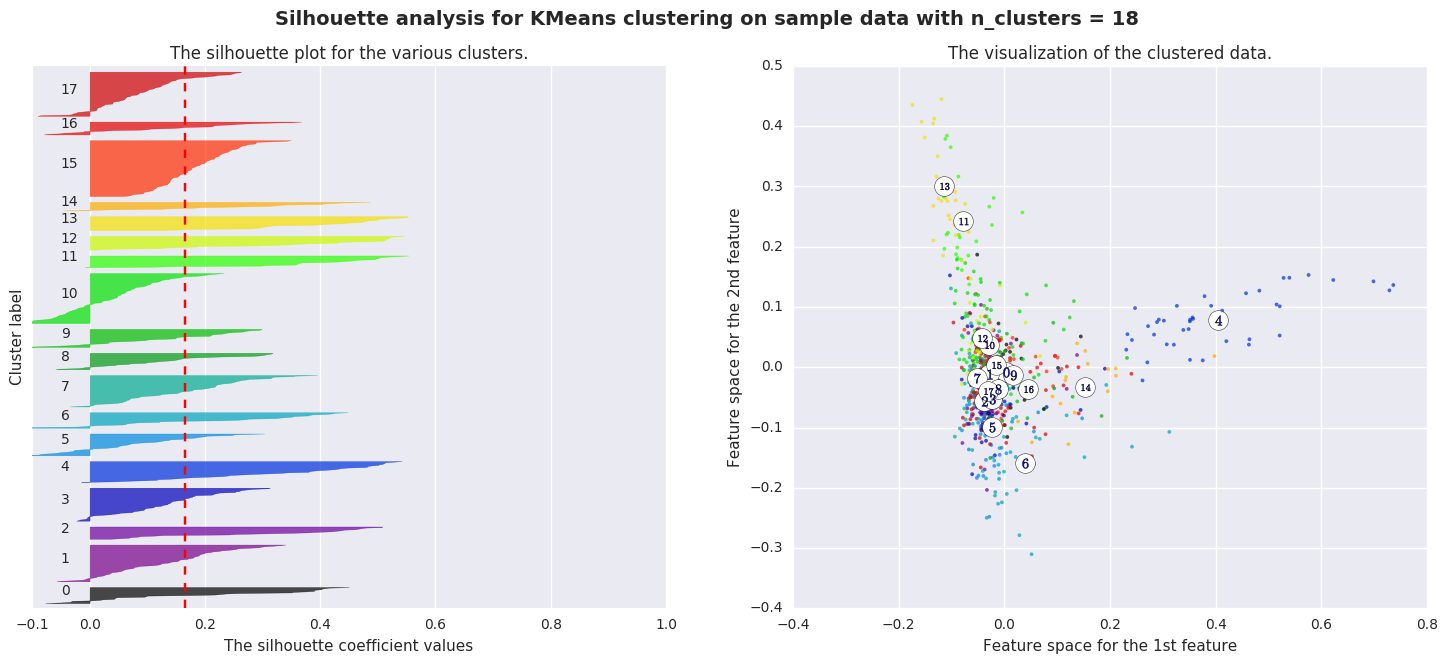

For n_clusters = 19 The average silhouette_score is : 0.167402885176


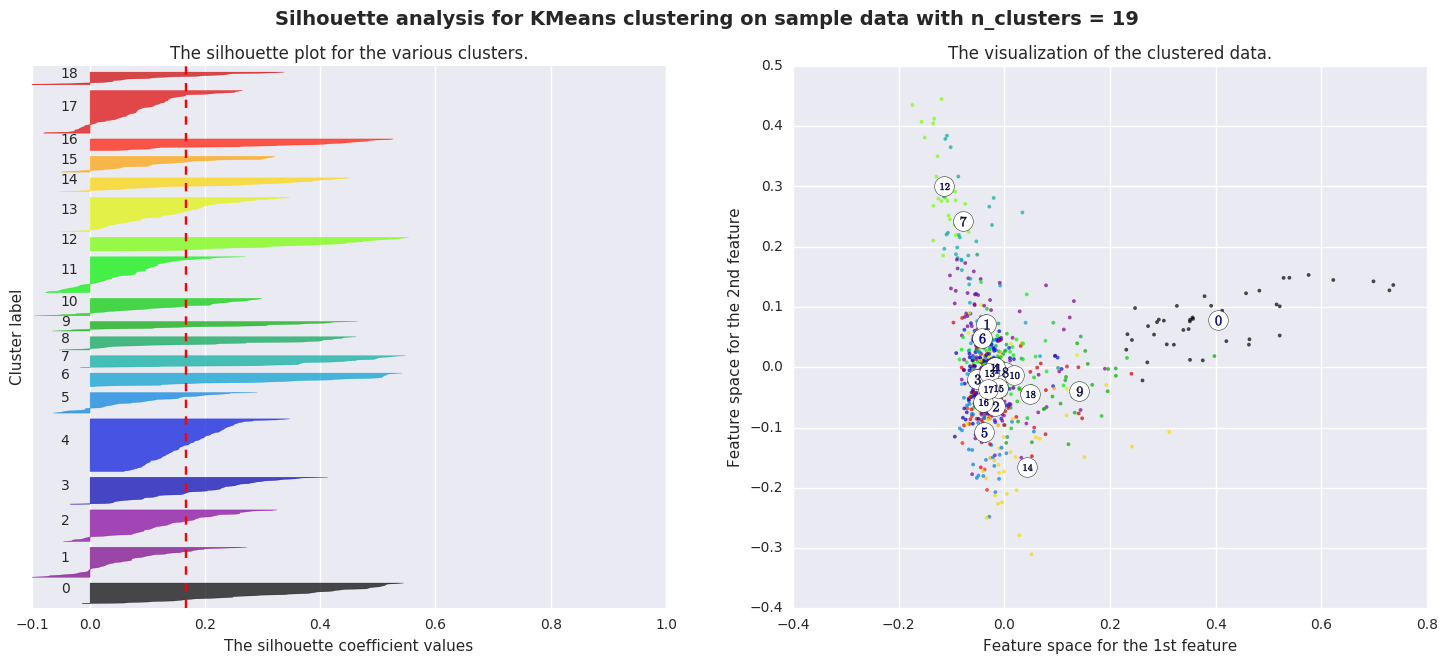

For n_clusters = 20 The average silhouette_score is : 0.165617735237


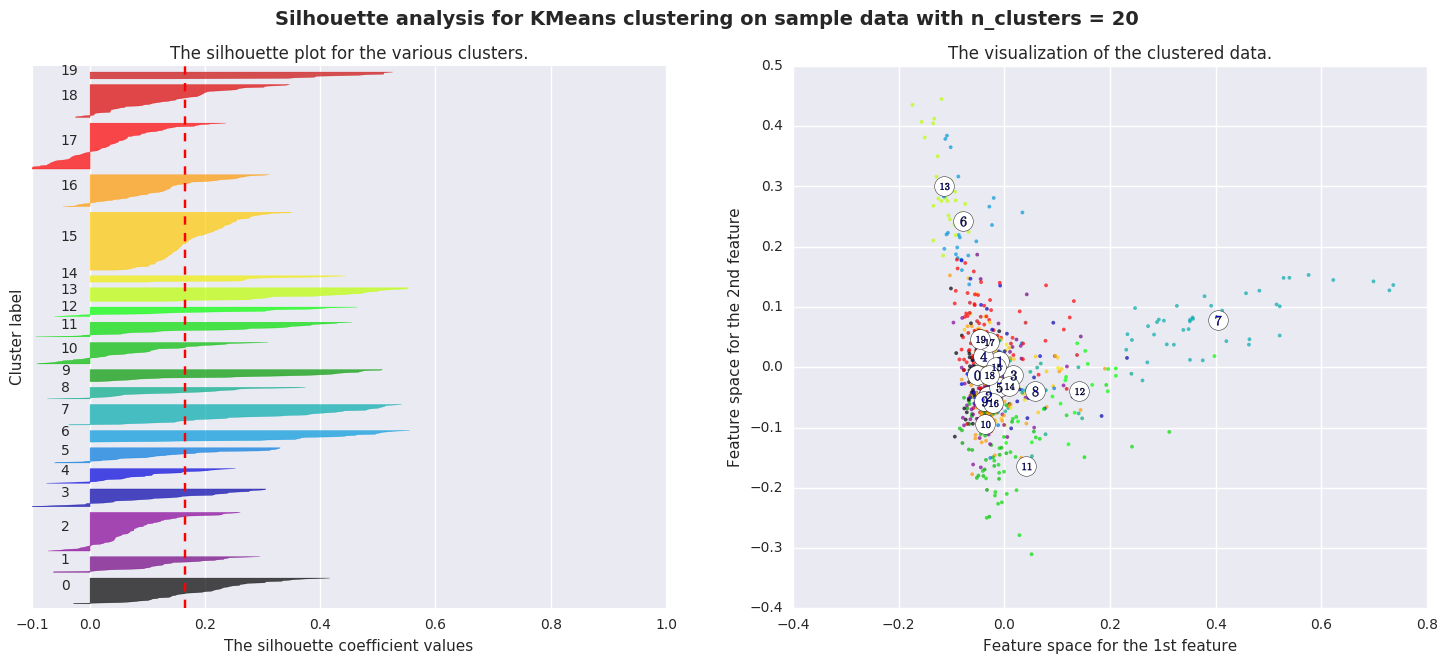

In [112]:
#First, let's use Silhouette method to find optimal number of clusters
range_n_clusters = [10, 15, 16, 17, 18, 19, 20]
X = reduced_data[:, :15]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

Top terms per cluster:
Cluster 0:
 black
 white
 race
 racism
 skin
 racial
 privilege
 think
 culture
 police


Cluster 1:
 think
 don
 day
 gay
 rape
 thing
 feel
 want
 person
 friends


Cluster 2:
 child
 children
 sex
 kids
 parents
 age
 drink
 kid
 think
 life


Cluster 3:
 trump
 hillary
 sanders
 clinton
 president
 bernie
 support
 country
 republican
 vote


Cluster 4:
 gender
 female
 feel
 identify
 don
 women
 male
 change
 want
 girls


Cluster 5:
 reddit
 posts
 downvote
 subreddits
 post
 sub
 comments
 content
 comment
 view


Cluster 6:
 body
 human
 life
 obese
 fat
 abortion
 pro
 population
 attractive
 food


Cluster 7:
 government
 president
 war
 terrorist
 think
 obama
 don
 world
 say
 country


Cluster 8:
 school
 read
 books
 universe
 didn
 reading
 edit
 high
 book
 libraries


Cluster 9:
 party
 vote
 voting
 parties
 election
 political
 votes
 voters
 voter
 candidates


Cluster 10:
 dog
 dogs
 meat
 eat
 animals
 eating
 animal
 food
 killed
 humans



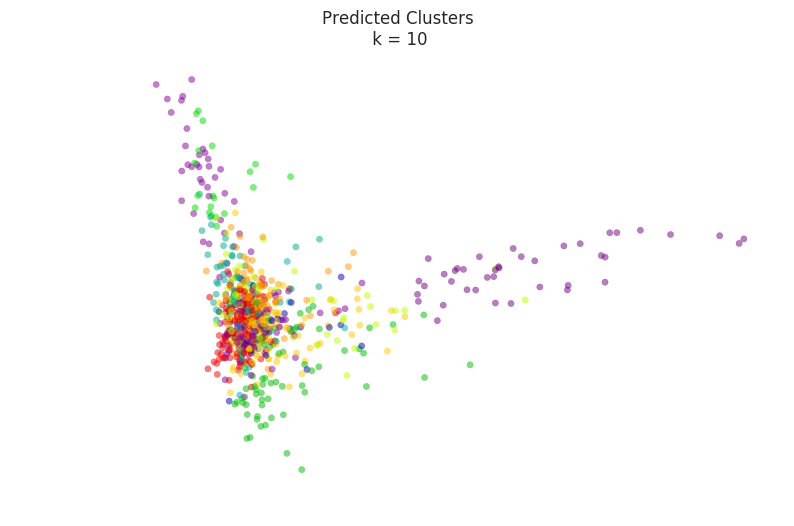

In [114]:
#It seems that when number of n_clusters is set to 10, it has the highest silhouette_score, 0.175818902297.

numClusters = 16
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(subTFVects)

#contents of the clusters
terms = TFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
labels = []
for i in range(numClusters):
    print("Cluster %d:" % i)
    label = ''
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
        label += terms[ind]+" "
    print('\n')
    labels.append(label)

#km.labels_
colors = matplotlib.cm.spectral(cluster_labels.astype(float) / n_clusters)
colors_p = [colors[l] for l in km.labels_]
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 10')
plt.show()

In [118]:
# clusteringDict={}
# for i in range(len(km.labels_)):
#     string = str(km.labels_[i])
#     #print(string)
#     if string in clusteringDict.keys():
#         clusteringDict[string].append(cpDF['name'][i])
#     else:
#         clusteringDict[string]= [cpDF['name'][i]]
# clusteringDict

# d = {'sub_text': sub, 'kmeans':km.labels_ }
# subDF = pd.DataFrame(data = d)
subDF['kmeans'] = km.labels_
subDF['kmeans_inter'] = subDF['kmeans'].apply(lambda x: labels[x])
subDF[:10]


,sub_text,tokenized_sub,normalized_sub,kmeans,kmeans_inter
0,I voted remain. I have just woken up to the Le...,"[I, voted, remain, ., I, have, just, woken, up...","[vote, remain, woken, leav, victori, concern, ...",7,government president war terrorist think obama...
1,Libraries provide communities many benefits ou...,"[Libraries, provide, communities, many, benefi...","[librari, provid, communiti, mani, benefit, ou...",8,school read books universe didn reading edit h...
2,Shameless Plug: [CMV post - State lotteries ar...,"[Shameless, Plug, :, [, CMV, post, -, State, l...","[shameless, plug, cmv, post, state, lotteri, r...",2,child children sex kids parents age drink kid ...
3,Hello CMV!\n\nFirst of all regarding my own id...,"[Hello, CMV, !, First, of, all, regarding, my,...","[hello, cmv, first, regard, idea, polit, would...",2,child children sex kids parents age drink kid ...
4,I feel like there's no reason to vote in the p...,"[I, feel, like, there, 's, no, reason, to, vot...","[feel, like, reason, vote, primari, presidenti...",9,party vote voting parties election political v...
5,**TL;DR: In order for the American people to h...,"[**TL, ;, DR, :, In, order, for, the, American...","[dr, order, american, peopl, signific, role, c...",9,party vote voting parties election political v...
6,I could not feel more strongly about this. It ...,"[I, could, not, feel, more, strongly, about, t...","[could, feel, strong, absolut, ridicul, person...",11,law police power person rights public think go...
7,"I'm Dutch, and here you can drink alcohol when...","[I, 'm, Dutch, ,, and, here, you, can, drink, ...","[dutch, drink, alcohol, sixteen, next, age, ra...",2,child children sex kids parents age drink kid ...
8,I believe that all countries should open their...,"[I, believe, that, all, countries, should, ope...","[believ, countri, open, border, fashion, membe...",12,money job jobs business work don make better c...
9,"The fact is that the vast majority of males, e...","[The, fact, is, that, the, vast, majority, of,...","[fact, vast, major, male, especi, circumcis, h...",13,god view believe time think don edit change re...


In [121]:
# clusteringDF = d
# clusteringDict={}
# for i in range(len(km.labels_)):
#     string = str(km.labels_[i])
#     #print(string)
#     if string in clusteringDict.keys():
#         clusteringDict[string].append(cpDF['name'][i])
#     else:
#         clusteringDict[string]= [cpDF['name'][i]]
# clusteringDict
cluster = []
percent = []
for i in range(16):
    cluster.append(labels[i])
    proportion = subDF[subDF['kmeans'] == i].shape[0]/subDF.shape[0]
    percent.append(proportion)
    #print(inter_kmeans(i), ": ", proportion, sep = "")
d = {'kmeans_num':np.array(range(16)), 'kmeans_inter': cluster, 'proportion': percent}
kmDF = pd.DataFrame(data = d).sort(['proportion'], ascending=[0])
kmDF

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:19: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,kmeans_inter,kmeans_num,proportion
13,god view believe time think don edit change re...,13,0.140794
11,law police power person rights public think go...,11,0.122744
1,think don day gay rape thing feel want person ...,1,0.113117
12,money job jobs business work don make better c...,12,0.084236
2,child children sex kids parents age drink kid ...,2,0.081829
7,government president war terrorist think obama...,7,0.080626
8,school read books universe didn reading edit h...,8,0.073406
5,reddit posts downvote subreddits post sub comm...,5,0.051745
15,men women woman man male gender female sports ...,15,0.048135
9,party vote voting parties election political v...,9,0.045728


# Topic modeling

In [105]:
#Similar parameters to before, but stricter max df and no max num occurrences
# cTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
# cTFVects = cTFVectorizer.fit_transform(cpDF['normalized_tokens'].sum())

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

subDF['reduced_tokens'] = subDF['normalized_sub'].apply(lambda x: dropMissing(x, TFVectorizer.vocabulary_.keys()))
subDF[:10]

,sub_text,tokenized_sub,normalized_sub,kmeans,kmeans_inter,reduced_tokens
0,"Say, for instance, that many properly controll...","[Say, ,, for, instance, ,, that, many, properl...","[say, instanc, mani, proper, control, studi, l...",8,black white time think make game film human ye...,"[say, control, set, effect, white, accept, tru..."
1,Whenever I see parents that are taking care of...,"[Whenever, I, see, parents, that, are, taking,...","[whenev, see, parent, take, care, children, di...",3,child children parents kid abortion think woma...,"[care, children, case, mental, ask, social, ch..."
2,I am very confident in the idea that people ca...,"[I, am, very, confident, in, the, idea, that, ...","[veri, confid, idea, peopl, use, internet, fuc...",0,sex word gay community literally definition se...,"[idea, use, internet, word, correct, say, care..."
3,If you possess the right to deprive and indivi...,"[If, you, possess, the, right, to, deprive, an...","[possess, right, depriv, individu, life, liber...",9,school law police evidence ve edit public worl...,"[right, life, law, think, lose, right, action,..."
4,"When I listen to the Beatles, I hear what is b...","[When, I, listen, to, the, Beatles, ,, I, hear...","[listen, beatl, hear, basic, equival, one, dir...",7,think view person feel believe edit change wan...,"[hear, basic, direct, song, time, thing, stop,..."
5,"Strong statement I know, I'm a bit on edge at ...","[Strong, statement, I, know, ,, I, 'm, a, bit,...","[strong, statement, know, bit, edg, moment, de...",3,child children parents kid abortion think woma...,"[strong, statement, know, bit, delta, later, f..."
6,I really don't understand how somebody can con...,"[I, really, do, n't, understand, how, somebody...","[realli, understand, somebodi, consid, themsel...",7,think view person feel believe edit change wan...,"[understand, support, mean, longer, enjoy, lif..."
7,I've been watching a couple of TED talks today...,"[I, 've, been, watching, a, couple, of, TED, t...","[watch, coupl, ted, talk, today, past, mayb, s...",7,think view person feel believe edit change wan...,"[watch, talk, today, past, seen, thing, talk, ..."
8,I'm hitting godwins law right away with this o...,"[I, 'm, hitting, godwins, law, right, away, wi...","[hit, godwin, law, right, away, one, term, peo...",8,black white time think make game film human ye...,"[hit, law, right, away, term, american, millio..."
9,"I'm not for or against GMO, I don't really car...","[I, 'm, not, for, or, against, GMO, ,, I, do, ...","[gmo, realli, care, true, real, advantag, poor...",7,think view person feel believe edit change wan...,"[care, true, real, poor, think, real, small, b..."


In [74]:
dictionary = gensim.corpora.Dictionary(subDF['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in subDF['reduced_tokens']]

#serializing the data
gensim.corpora.MmCorpus.serialize('sub.mm', corpus)
mm = gensim.corpora.MmCorpus('sub.mm')

lda = gensim.models.ldamodel.LdaModel(corpus=mm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [75]:
ldaDF = pandas.DataFrame({
        'text' : subDF['sub_text'],
        'topics' : [lda[dictionary.doc2bow(l)] for l in subDF['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(lda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF

,text,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,"Say, for instance, that many properly controll...","[(4, 0.193417526487), (9, 0.789331609662)]",0.000000,0.000000,0.000000,0.000000,0.193418,0.000000,0.000000,0.000000,0.000000,0.789332
1,Whenever I see parents that are taking care of...,"[(6, 0.977408278225)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.977408,0.000000,0.000000,0.000000
2,I am very confident in the idea that people ca...,"[(2, 0.370250211346), (9, 0.598210325316)]",0.000000,0.000000,0.370250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.598210
3,If you possess the right to deprive and indivi...,"[(2, 0.034807400284), (3, 0.18873977348), (4, ...",0.000000,0.000000,0.034807,0.188740,0.102255,0.000000,0.000000,0.000000,0.000000,0.668725
4,"When I listen to the Beatles, I hear what is b...","[(4, 0.325636396017), (6, 0.299229542054), (8,...",0.000000,0.000000,0.000000,0.000000,0.325636,0.000000,0.299230,0.000000,0.348668,0.000000
5,"Strong statement I know, I'm a bit on edge at ...","[(3, 0.204413994777), (6, 0.783448669769)]",0.000000,0.000000,0.000000,0.204414,0.000000,0.000000,0.783449,0.000000,0.000000,0.000000
6,I really don't understand how somebody can con...,"[(1, 0.504658219218), (8, 0.480190077049)]",0.000000,0.504658,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.480190,0.000000
7,I've been watching a couple of TED talks today...,"[(2, 0.282019797492), (6, 0.699896065373)]",0.000000,0.000000,0.282020,0.000000,0.000000,0.000000,0.699896,0.000000,0.000000,0.000000
8,I'm hitting godwins law right away with this o...,"[(3, 0.361629926691), (4, 0.622943618117)]",0.000000,0.000000,0.000000,0.361630,0.622944,0.000000,0.000000,0.000000,0.000000,0.000000
9,"I'm not for or against GMO, I don't really car...","[(0, 0.806519607398), (6, 0.173354470082)]",0.806520,0.000000,0.000000,0.000000,0.000000,0.000000,0.173354,0.000000,0.000000,0.000000


In [76]:
#Dataframe that shows top words in each topic
topicsDict = {}
for topicNum in range(lda.num_topics):
    topicWords = [w for w, p in lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords
    #print(topicWords)

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
0,make,live,view,think,think,thing,child,think,think,use
1,think,think,think,view,make,need,say,make,say,think
2,view,make,time,say,way,make,think,view,life,want
3,use,law,make,feel,time,human,feel,person,thing,right
4,reason,person,post,problem,say,men,men,time,person,women
5,way,edit,thing,day,want,think,make,say,view,vote
6,reddit,thing,want,help,women,feel,good,work,work,say
7,feel,feel,know,know,man,time,edit,point,make,men
8,thing,new,edit,school,view,right,right,read,know,mean
9,edit,want,way,money,reason,year,women,want,feel,way


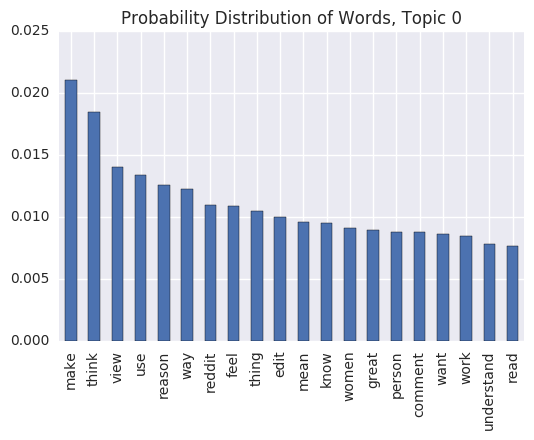

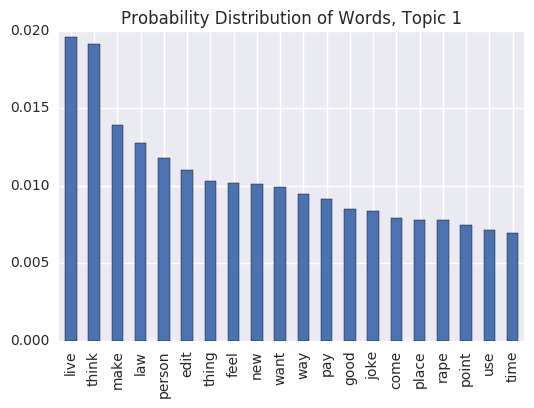

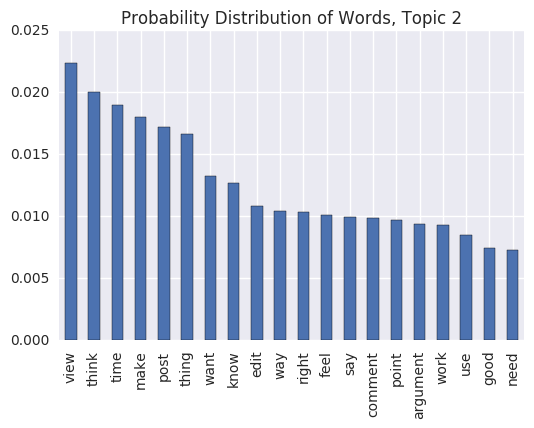

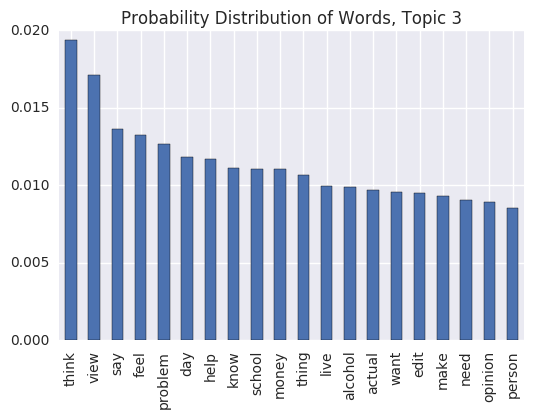

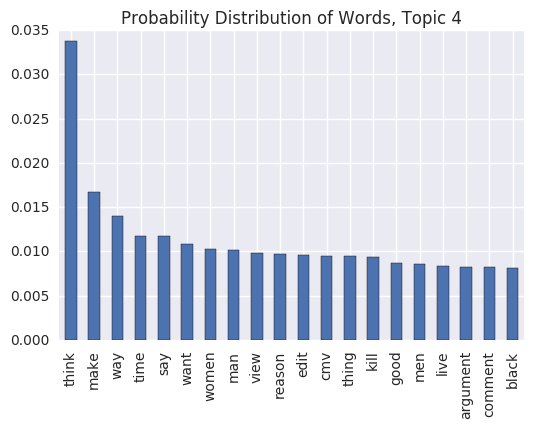

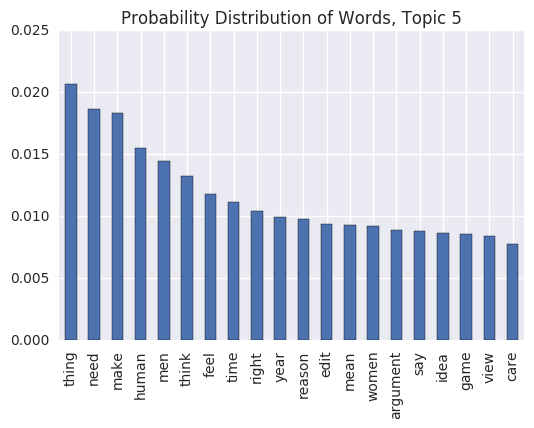

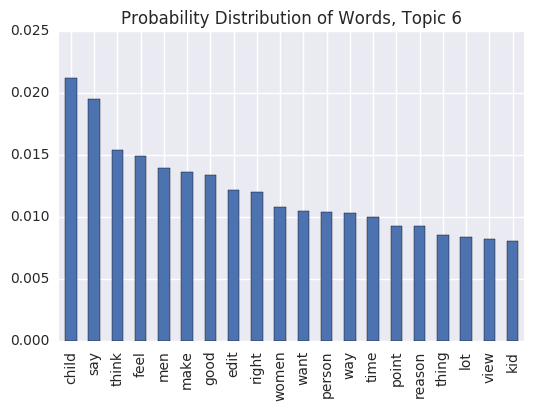

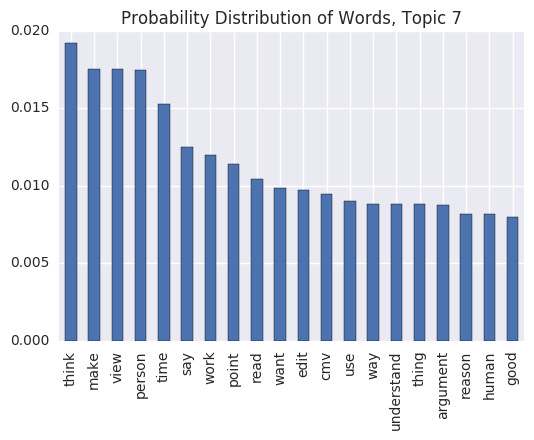

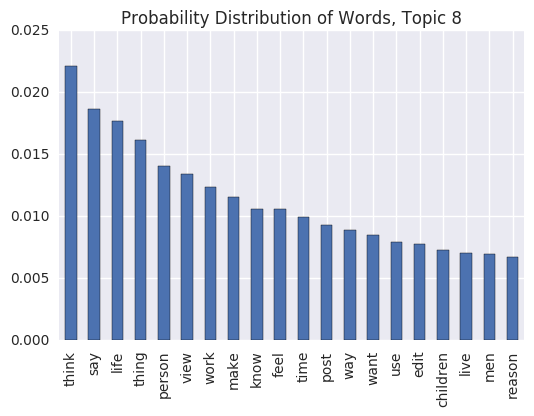

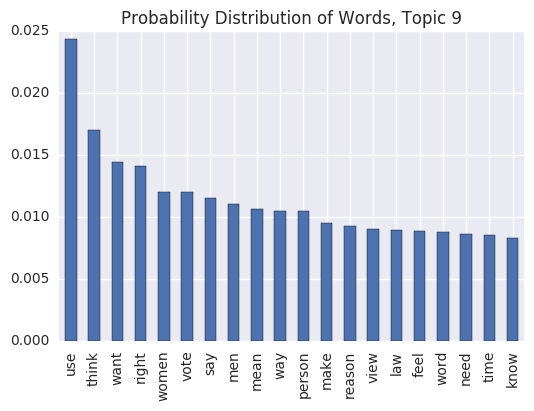

In [87]:
#Visualize the topic-word loadings
for i in np.arange(10):
    topic_df = pandas.DataFrame(lda.show_topic(i, topn=20))
    #print(topic_df)
    plt.figure()
    topic_df.plot.bar(legend = False)
    plt.title('Probability Distribution of Words, Topic {}'.format(i))
    xtickvals = np.arange(20)
    xticklabs = topic_df[0]
    plt.xticks(xtickvals, xticklabs, rotation='vertical', fontsize = 10)
    plt.show()

In [83]:
# ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
# ldaDFVisN = ldaDF[:10][['sub_text']]
# ldaDFVis = ldaDF.as_matrix(columns=None)
#ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
#ldaDFV

TypeError: unorderable types: str() < int()

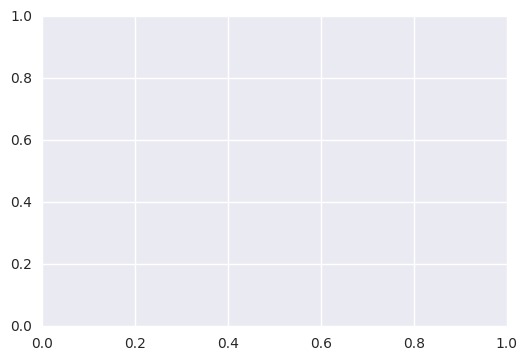

In [85]:
# #Visualize the document-topic loadings as a stacked bar plot
# N = subDF.shape[0]
# ind = np.arange(N)
# K = lda.num_topics  # N documents, K topics
# ind = np.arange(N)  # the x-axis locations for the novels
# width = 0.5  # the width of the bars
# plots = []
# height_cumulative = np.zeros(N)

# for k in range(K):
#     color = plt.cm.coolwarm(k/K, 1)
#     if k == 0:
#         p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
#     else:
#         p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
#     height_cumulative += ldaDFVis[:, k]
#     plots.append(p)
    

# plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
# plt.ylabel('Topics')

# plt.title('Topics in Chinese Politics')
# #plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

# plt.yticks(np.arange(0, 1, 10))
# topic_labels = ['Topic #{}'.format(k) for k in range(K)]
# plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

# plt.show()

Since the resulted topics are not significantly distinctive from each other, we decide to use out clustering result as our partitioning for this dataset and use it as a feature for our feature matrix for later analysis.

In [126]:
subDF.to_pickle("sub_data.pkl")
subDF[:10]

,sub_text,tokenized_sub,normalized_sub,kmeans,kmeans_inter
0,I voted remain. I have just woken up to the Le...,"[I, voted, remain, ., I, have, just, woken, up...","[vote, remain, woken, leav, victori, concern, ...",7,government president war terrorist think obama...
1,Libraries provide communities many benefits ou...,"[Libraries, provide, communities, many, benefi...","[librari, provid, communiti, mani, benefit, ou...",8,school read books universe didn reading edit h...
2,Shameless Plug: [CMV post - State lotteries ar...,"[Shameless, Plug, :, [, CMV, post, -, State, l...","[shameless, plug, cmv, post, state, lotteri, r...",2,child children sex kids parents age drink kid ...
3,Hello CMV!\n\nFirst of all regarding my own id...,"[Hello, CMV, !, First, of, all, regarding, my,...","[hello, cmv, first, regard, idea, polit, would...",2,child children sex kids parents age drink kid ...
4,I feel like there's no reason to vote in the p...,"[I, feel, like, there, 's, no, reason, to, vot...","[feel, like, reason, vote, primari, presidenti...",9,party vote voting parties election political v...
5,**TL;DR: In order for the American people to h...,"[**TL, ;, DR, :, In, order, for, the, American...","[dr, order, american, peopl, signific, role, c...",9,party vote voting parties election political v...
6,I could not feel more strongly about this. It ...,"[I, could, not, feel, more, strongly, about, t...","[could, feel, strong, absolut, ridicul, person...",11,law police power person rights public think go...
7,"I'm Dutch, and here you can drink alcohol when...","[I, 'm, Dutch, ,, and, here, you, can, drink, ...","[dutch, drink, alcohol, sixteen, next, age, ra...",2,child children sex kids parents age drink kid ...
8,I believe that all countries should open their...,"[I, believe, that, all, countries, should, ope...","[believ, countri, open, border, fashion, membe...",12,money job jobs business work don make better c...
9,"The fact is that the vast majority of males, e...","[The, fact, is, that, the, vast, majority, of,...","[fact, vast, major, male, especi, circumcis, h...",13,god view believe time think don edit change re...


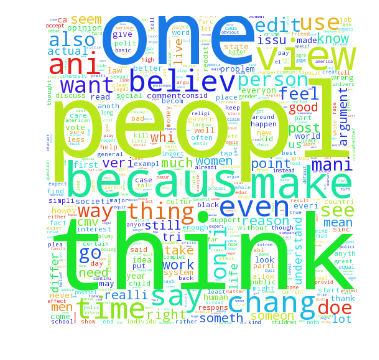

In [127]:
#Just for fun: wordcloud for our posts
#Wordcloud
wc = wordcloud.WordCloud(background_color="white", max_words=500, width= 1000, height = 1000, mode ='RGBA', scale=.5).\
generate(' '.join(subDF['normalized_sub'].sum()))
plt.imshow(wc)
plt.axis("off")
plt.savefig("CMVposts_word_cloud.pdf", format = 'pdf')